# Описание проекта

**Проект:** "HR-аналитика"<br>
<br>
**Заказчик** — компания «Работа с заботой»<br>
**Цель проекта** - Построение моделей, прогнозирующих уровень удовлетворенности сотрудника и увольнение сотрудника по его инициативе.

<br>

**Задача 1: Разработка модели прогноза уровня удовлетворённости сотрудника**
<br>
Данные:  
* Тренировочная выборка: `train_job_satisfaction_rate.csv`
* Входные признаки тестовой выборки: `test_features.csv`
* Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`
 <br>
 
**Характеристики и показатели :**
<br>
* `id` — уникальный идентификатор сотрудника;
* `dept` — отдел, в котором работает сотрудник;
* `level` — уровень занимаемой должности;
* `workload` — уровень загруженности сотрудника;
* `employment_years` — длительность работы в компании (в годах);
* `last_year_promo` — показывает, было ли повышение за последний год;
* `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
* `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
* `salary` — ежемесячная зарплата сотрудника;
* `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.
<br>
**Задача 2: Разработка модели прогноза увольнений сотрудников по их инициативе**
<br>
Данные:  
* Тренировочная выборка: `train_job_satisfaction_rate.csv`
* Входные признаки тестовой выборки: `test_features.csv`
* Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`
 <br>

**Этапы реализации проекта:**
* Разработка модели прогноза уровня удовлетворённости сотрудника
    * Загрузка данных
    * Предобработка данных
    * Исследовательский анализ данных
    * Подготовка данных
    * Обучение моделей
* Разработка модели прогноза увольнений сотрудников по их инициативе
    * Загрузка данных
    * Предобработка данных
    * Исследовательский анализ данных
    * Формирование нового входного признака
    * Подготовка данных
    * Обучение модели

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from phik import phik_matrix

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)

import shap
from scipy. stats import ttest_ind

from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import (LinearRegression, LogisticRegression)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import(
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    MinMaxScaler,
    StandardScaler
)

from sklearn.metrics import (
        r2_score,
        mean_absolute_error,
        roc_auc_score,
        make_scorer,
        mean_squared_error
                            )

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

C:\Users\lopat\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option("display.max_columns", None) # Отображать все поля DF
pd.set_option('display.max_colwidth', None)  # Отображать все содержание полей DF

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

bold_start = color.BLUE
bold_end   = color.END

# Функции

### calc_smape - метрика SMAPE

In [3]:
def calc_smape(y_true, y_pred):
    calc_smape_ = 100 / len(y_true) * np.sum( np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2))
    return calc_smape_

### categorical_property_visualization - визуализация категориальных признаков

In [4]:
def categorical_property_visualization(
    data_,
    indexes_=[],
    titles_=[],
    values_='',
    aggfunc_='count',
    nrows_=2,
    ncols_=3,
    figsize_=(20, 7),
    title_ = ''):
    columns = data_.columns
    
    row_ind = 0
    col_ind = 0
    subplot_ind = 0
    
    if nrows_ * ncols_ < len(indexes_):
        print(Несоответствие - nrows_ * ncols_ < len(indexes_))
        return

    fig, axes = plt.subplots(nrows=nrows_, ncols=ncols_, figsize=figsize_)
    fig.suptitle(title_, fontsize=20)
    
    for x in axes.ravel():
        x.axis("off")    
        #print(row_ind, col_ind)
        #print(len(axes.shape))

    for ind in indexes_:
        if len(axes.shape) == 1:
            current_ax = axes[subplot_ind]
        else:
            current_ax = axes[row_ind, col_ind]
            
#        current_ax.set_visible(False)
        
        data_.pivot_table(
                index=ind,
                values=values_,
                aggfunc=aggfunc_
            ).plot(
                kind='pie',
                ax = current_ax,
                y='id',
                autopct='%1.0f%%'
            )
        #axes[row_ind, col_ind].set_title(titles[subplot_ind])
        #axes[row_ind, col_ind].get_legend().remove()
        current_ax.set_title(titles[subplot_ind])
        current_ax.get_legend().remove()
    
        subplot_ind += 1
        col_ind += 1
        if col_ind == ncols_: #3
            col_ind = 0
            row_ind += 1

### distribution_visualization - визуализация зависимостей

In [5]:
def distribution_visualization(
    research_field_,
    research_field_title_x_,
    research_field_title_y_,
    property_fields_,
    property_labels_,
    data_fields_,
    labels_,
    data_,
    uni_color_ = '',
    research_field_histplot_title_y_ = '',
    fig_size_ = [25, 3]
):
    column_count_ = len(property_fields_) + 1
    
    row_count_ = 1
    subplot_index_ = 1
    data_field_ind = 0
    
    for data in data_fields_:
    #    print('Дата - ', data)
        plt.figure(figsize=fig_size_)
    
        subplot_index_ = 1
        plt.subplot(1, column_count_, subplot_index_)
        if uni_color_ == '':
            sns.histplot(x = research_field_, kde = True, hue = data, data = data_, bins = 50) #, color='orange'
        else:
            sns.histplot(x = research_field_, kde = True, data = data_, bins = 50, color = uni_color_)

        title_str = f'Распределение по признаку - {labels_[data_field_ind]}'
        plt.title(title_str)
        plt.xlabel(research_field_title_x_)
        plt.ylabel(research_field_histplot_title_y_)
        #plt.legend(title=' ', labels=ferma_data_df[data]) #.unique()
        
        subplot_index_ += 1
        property_fields = 0
        for property in property_fields_:
    #        print('Свойство - ', property)
    #        print('subplot_index_ - ', subplot_index_)
            for value in data_[data].unique():
                query_str = f'{data} == "{value}"'
    #            print('query_str = ', query_str)
    #            print(ferma_data_df.query(query_str))
    
                plt.subplot(1, column_count_, subplot_index_)
                if uni_color_ == '':
                    sns.scatterplot(data = data_.query(query_str), x = property, y = research_field_, label = value)
#                    sns.scatterplot(data = data_.query(query_str), y = property, x = research_field_, label = value)
                else:
                    sns.scatterplot(data = data_.query(query_str), x = property, y = research_field_, label = value, color=uni_color_)
#                    sns.scatterplot(data = data_.query(query_str), y = property, x = research_field_, label = value, color=uni_color_)
            subplot_index_ += 1
            plt.xlabel(property_labels_[property_fields])
            plt.ylabel(research_field_title_x_)
            property_fields += 1
        data_field_ind += 1
        plt.show()

### column_analiser - визуализация числовых признаков

In [6]:
def column_analiser(
    df_,
    column_,
    x_label='',
    y_label='',
    print_unique = False,
    bins_= 70):

    print(bold_start, f'Поле : {column_} - {x_label}', bold_end)
    print('')
    
    print(df_[column_].describe())
    if print_unique:
        print('Список значений')
        print(df_[column_].unique())
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    df_[column_].plot(kind='box', ax=axes[0], vert=False)
    axes[0].set_ylabel(y_label)
    
    axes[1] = plt.hist(
        df_[column_],
        bins=bins_,
    )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Распределение')    

    plt.show()

### df_inf - вывод информации о датасете

In [7]:
def df_inf(df, head_row=5, drop_duplicates_flag=False):
    try:
        df_name = df.name
        print(bold_start,'Имя:', df_name, bold_end)
    except:
        df_name = 'Не определено'
        display(bold_start,'Имя: Не определено', bold_end)
    print('')

    print(bold_start, df_name, '(первые', head_row, 'строк)', bold_end)
    display(df.head(head_row))

    
    print(bold_start,'Информация: ', bold_end)
    df.info()
    print('')

    print(bold_start,'Описание полей: ', bold_end)
    display(df.describe())
    print('')

    print(bold_start,'Пропуски: ', bold_end)
    display(df.isna().sum().T)
    print('')
    
    df_duplicates = []
    df_duplicates = df[df.duplicated()]

    if len(df_duplicates) > 0:
        print(bold_start,'Количество дубликатов:',len(df_duplicates), bold_end)
        print(bold_start,'Дубликаты (первые', head_row, 'строк)', bold_end)
        display(df_duplicates.head(head_row))
        if drop_duplicates_flag:
            print(bold_start,'Дубликаты удалены!', bold_end)
            df.drop_duplicates(keep = 'first', inplace = True)
            print(bold_start,'Количество дубликатов после удаления:',len(df_duplicates), bold_end)
    else:
        print(bold_start,'Дубликаты не обнаружены!', bold_end)
    return df_duplicates

### check_categorical_fields() - вывод уникальных значений полей

In [8]:
def check_categorical_fields(df_, fields_lst):
    for field in fields_lst:
        if df_[field].isna().sum() > 0:
            display(f'Поле - {field} {df_[field].unique()}')
        else:
            display(f'Поле - field {np.sort(df_[field].unique())}')

### attrition_visualization - Визуализация текучки кадров

In [9]:
def attrition_visualization(index_, x_label_, df_):
    test_features_quit_pt = df_.pivot_table(
        index = index_,
        values=['id'],
        columns=['quit'],
        aggfunc=['count']
    )
    test_features_quit_pt.reset_index(inplace=True)
    test_features_quit_pt.columns = [index_, 'no', 'yes']
    
    test_features_quit_pt['Работают'] = (test_features_quit_pt['no'] / (test_features_quit_pt['no'] + test_features_quit_pt['yes']))*100
    test_features_quit_pt['Уволились'] = (test_features_quit_pt['yes'] / (test_features_quit_pt['no'] + test_features_quit_pt['yes']))*100
    
    test_features_quit_pt = test_features_quit_pt.drop(['yes', 'no'], axis= 1 , inplace= False )
    test_features_quit_pt.set_index(index_, inplace=True)
    ax = test_features_quit_pt.plot(kind='bar', stacked = True , color=['steelblue', 'red'], figsize=[4, 4])
    plt.xlabel(x_label_);

# Задача 1 - Разработка модели прогноза уровня удовлетворённости сотрудника

## Загрузка данных

In [10]:
#train_job_satisfaction_rate_df = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_job_satisfaction_rate_df = pd.read_csv('train_job_satisfaction_rate.csv')
train_job_satisfaction_rate_df.name = 'train_job_satisfaction_rate_df'

#test_features_df = pd.read_csv('/datasets/test_features.csv')
test_features_df = pd.read_csv('test_features.csv')
test_features_df.name = 'test_features_df'

#test_target_job_satisfaction_rate_df = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target_job_satisfaction_rate_df = pd.read_csv('test_target_job_satisfaction_rate.csv')
test_target_job_satisfaction_rate_df.name = 'test_target_job_satisfaction_rate_df'

display(train_job_satisfaction_rate_df.head(3))
display(test_features_df.head(3))
display(test_target_job_satisfaction_rate_df.head(3))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60


In [11]:
train_job_satisfaction_rate_df.info()
print('---------------------------------------------------------------------------------------------------------')
train_job_satisfaction_rate_df = train_job_satisfaction_rate_df.drop_duplicates()
train_job_satisfaction_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 co

### Выводы

Данные загружены без ошибок.

## Предобработка данных

### train_job_satisfaction_rate_df - Тренировочная выборка

In [12]:
duplicates = df_inf(train_job_satisfaction_rate_df, head_row=5, drop_duplicates_flag=False)

'\x1b'

'Имя: Не определено'

'\x1b'


 Не определено (первые 5 строк) 


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

 Описание полей:  


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000



 Пропуски:  


id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


 Дубликаты не обнаружены! 


In [13]:
display(train_job_satisfaction_rate_df.query('dept.isna()'))
display(train_job_satisfaction_rate_df.query('level.isna()'))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [14]:
check_categorical_fields(train_job_satisfaction_rate_df, fields_lst=[
    'dept',
    'level',
    'workload',    
    'last_year_promo',
    'last_year_violations'])

"Поле - dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]"

"Поле - level ['junior' 'middle' 'sinior' nan]"

"Поле - field ['high' 'low' 'medium']"

"Поле - field ['no' 'yes']"

"Поле - field ['no' 'yes']"

### test_features_df - Входные признаки тестовой выборки

In [15]:
duplicates = df_inf(test_features_df, head_row=5, drop_duplicates_flag=False)

 Имя: test_features_df 

 test_features_df (первые 5 строк) 


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

 Описание полей:  


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



 Пропуски:  


id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


 Дубликаты не обнаружены! 


In [16]:
display(test_features_df.query('dept.isna()'))
display(test_features_df.query('level.isna()'))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


### test_target_job_satisfaction_rate_df - Целевой признак тестовой выборки

In [17]:
duplicates = df_inf(test_target_job_satisfaction_rate_df, head_row=5, drop_duplicates_flag=False)

 Имя: test_target_job_satisfaction_rate_df 

 test_target_job_satisfaction_rate_df (первые 5 строк) 


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB

 Описание полей:  


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000



 Пропуски:  


id                       0
job_satisfaction_rate    0
dtype: int64


 Дубликаты не обнаружены! 


In [18]:
job_satisfaction_rate_check = test_target_job_satisfaction_rate_df['job_satisfaction_rate'].sum()
test_features_df = pd.merge(test_features_df, test_target_job_satisfaction_rate_df, on='id', sort=True)

print(bold_start, 'job_satisfaction_rate_check = ', bold_end, job_satisfaction_rate_check)
print(bold_start, 'job_satisfaction_rate =', bold_end, test_features_df['job_satisfaction_rate'].sum())
test_features_df.info()
test_features_df.head()

 job_satisfaction_rate_check =   1097.56
 job_satisfaction_rate =  1097.56
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,0.80
1,100480,marketing,junior,low,4,no,no,4,16800,0.84
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79
3,100610,sales,middle,medium,5,no,no,4,43200,0.75
4,100692,sales,middle,high,6,no,no,4,48000,0.69


### Выводы

* Данные соответствуют описанию.
* Дубликаты не обнаружены.
* Пропуски будут обработаны на этапе подготовки данных при разработке моделей.

## Исследование данных

### train_job_satisfaction_rate_df

 Поле : employment_years - employment_years 

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


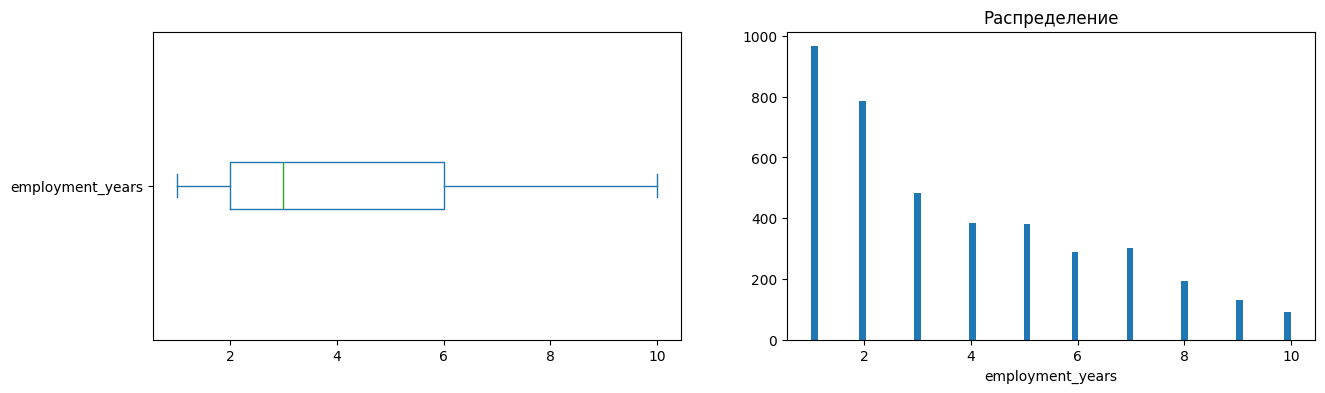

 Поле : supervisor_evaluation - supervisor_evaluation 

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


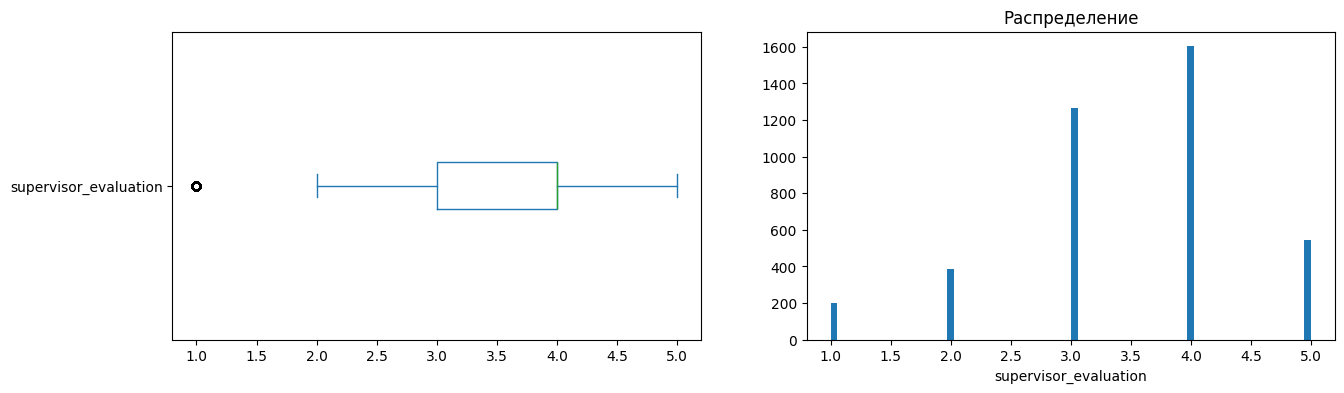

 Поле : salary - salary 

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


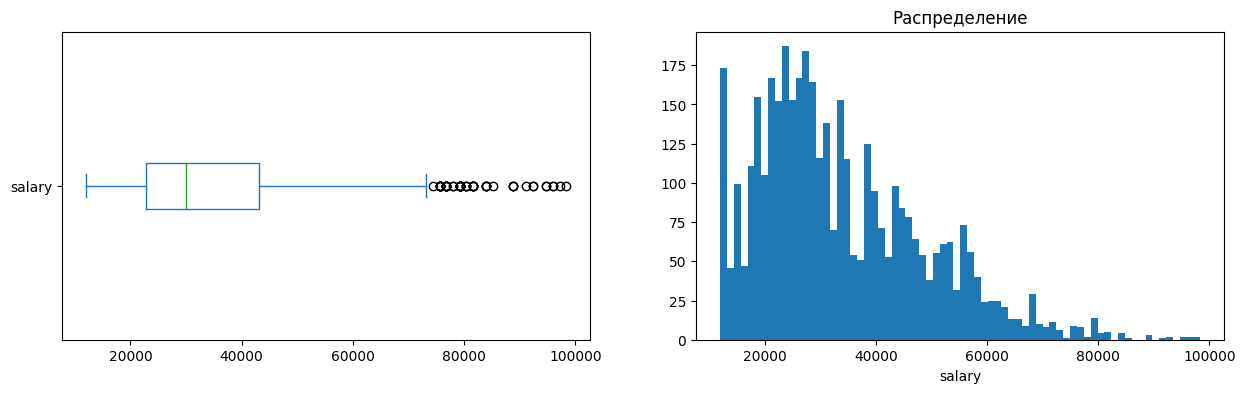

 Поле : job_satisfaction_rate - job_satisfaction_rate 

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


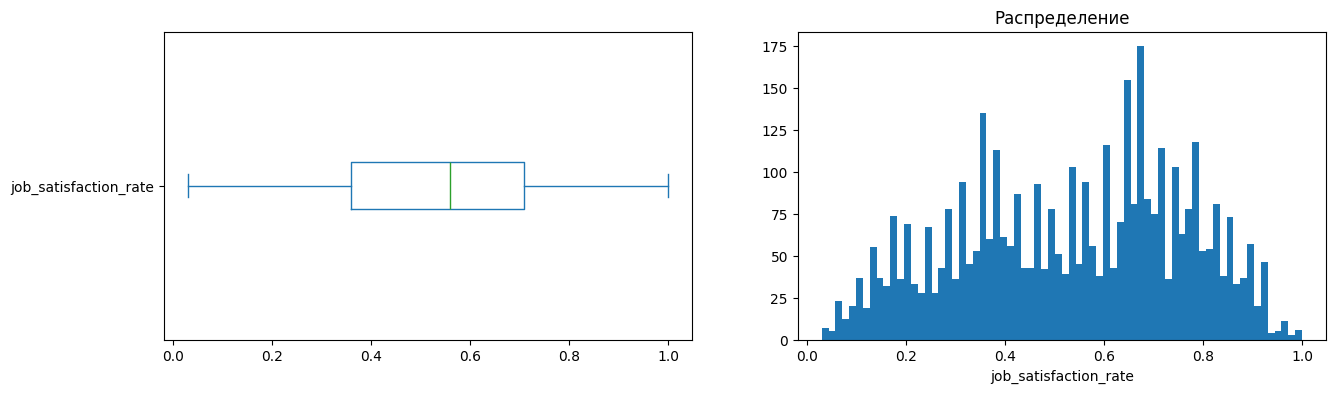

In [19]:
column_lst = [
    'employment_years',
    'supervisor_evaluation',
    'salary',
    'job_satisfaction_rate'
]

for column in column_lst:
    column_analiser(
        train_job_satisfaction_rate_df,
        column,
        x_label = column,
        y_label = '',
        print_unique = False
               )

### test_features_df

 Поле : employment_years - employment_years 

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


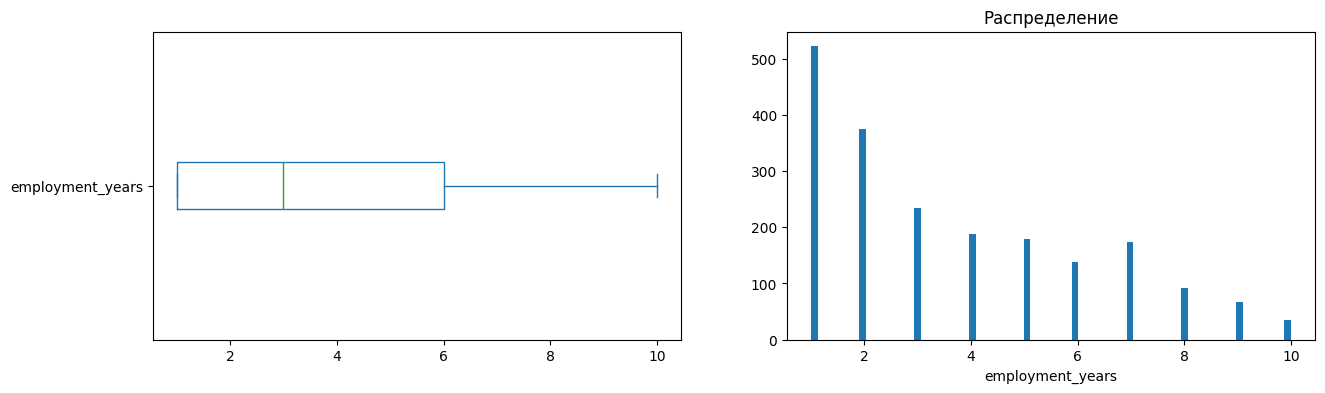

 Поле : supervisor_evaluation - supervisor_evaluation 

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


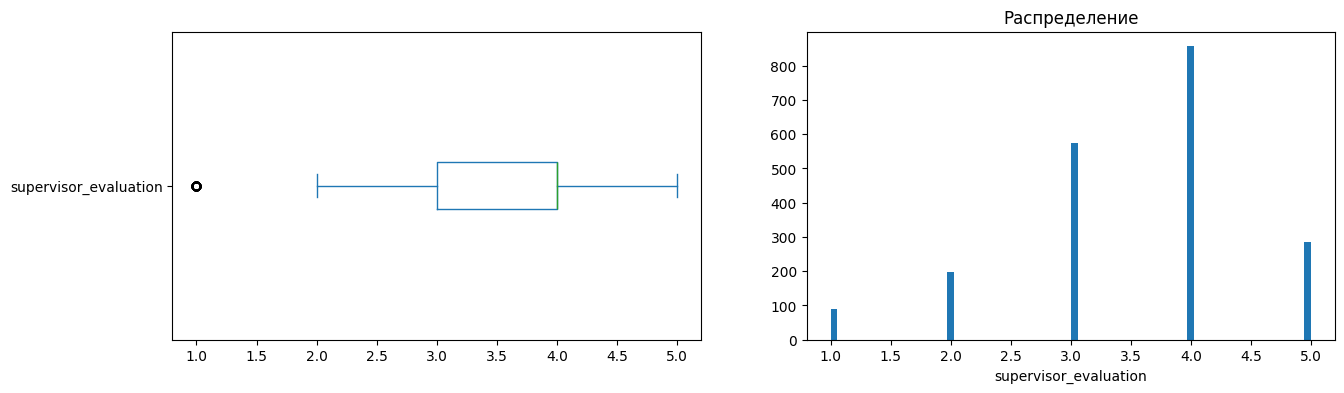

 Поле : salary - salary 

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


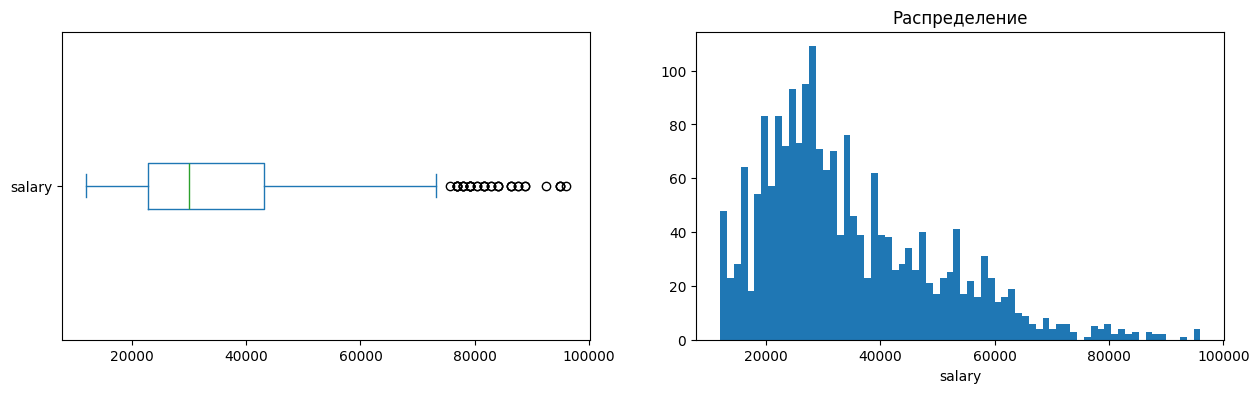

 Поле : job_satisfaction_rate - job_satisfaction_rate 

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


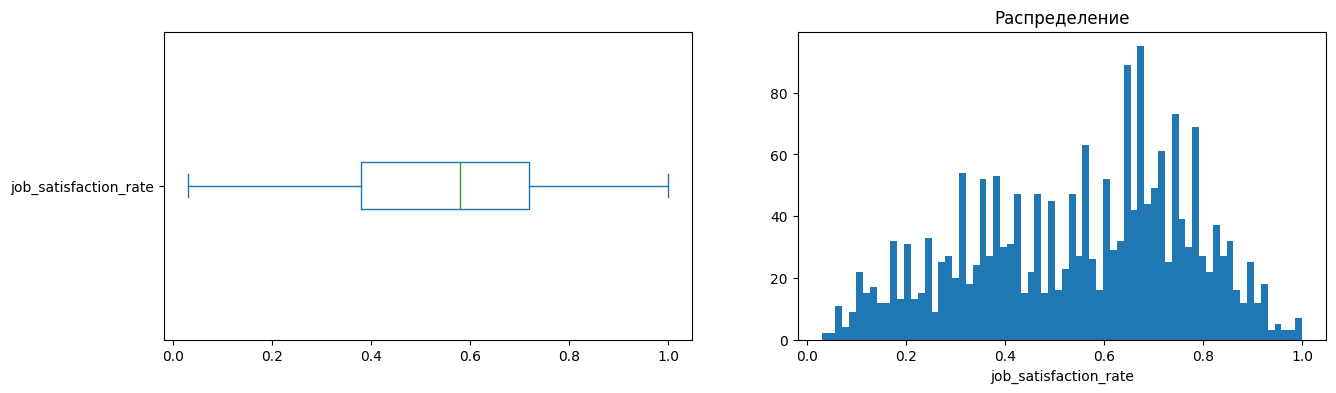

In [20]:
column_lst = [
    'employment_years',
    'supervisor_evaluation',
    'salary',
    'job_satisfaction_rate'
]

for column in column_lst:
    column_analiser(
        test_features_df,
        column,
        x_label = column,
        y_label = '',
        print_unique = False
               )


### Категориальные признаки

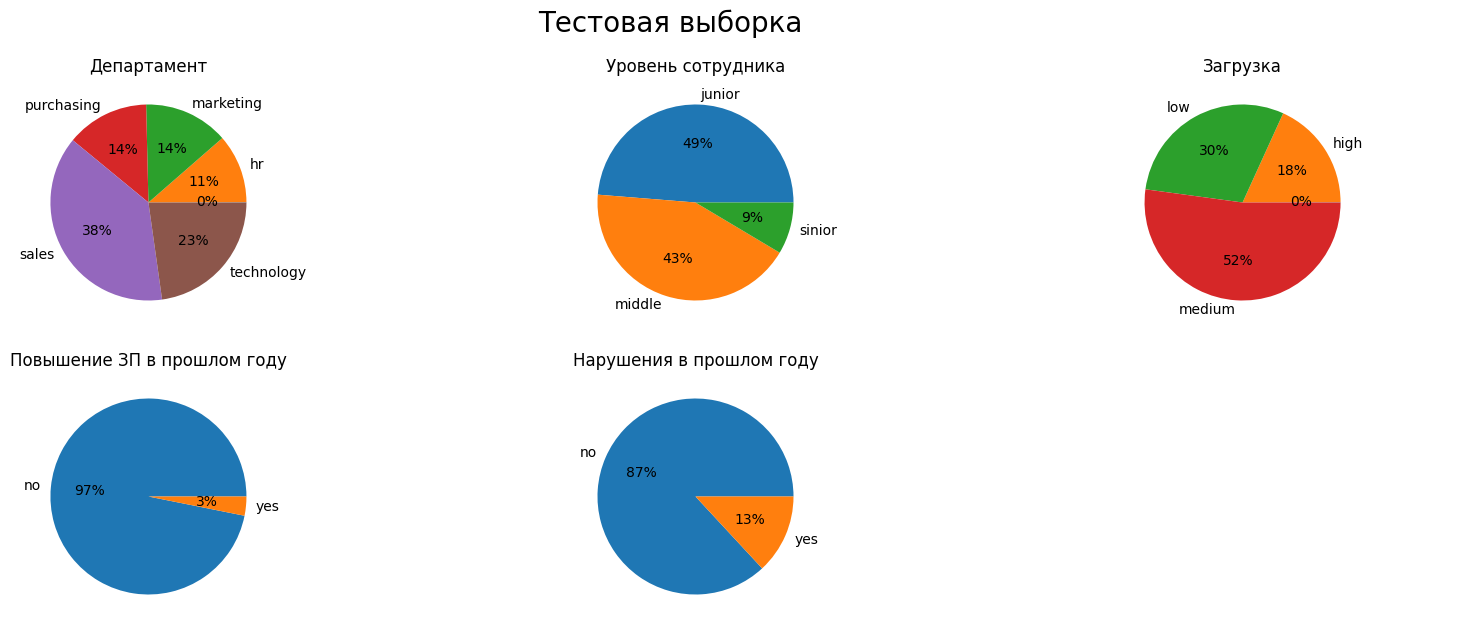

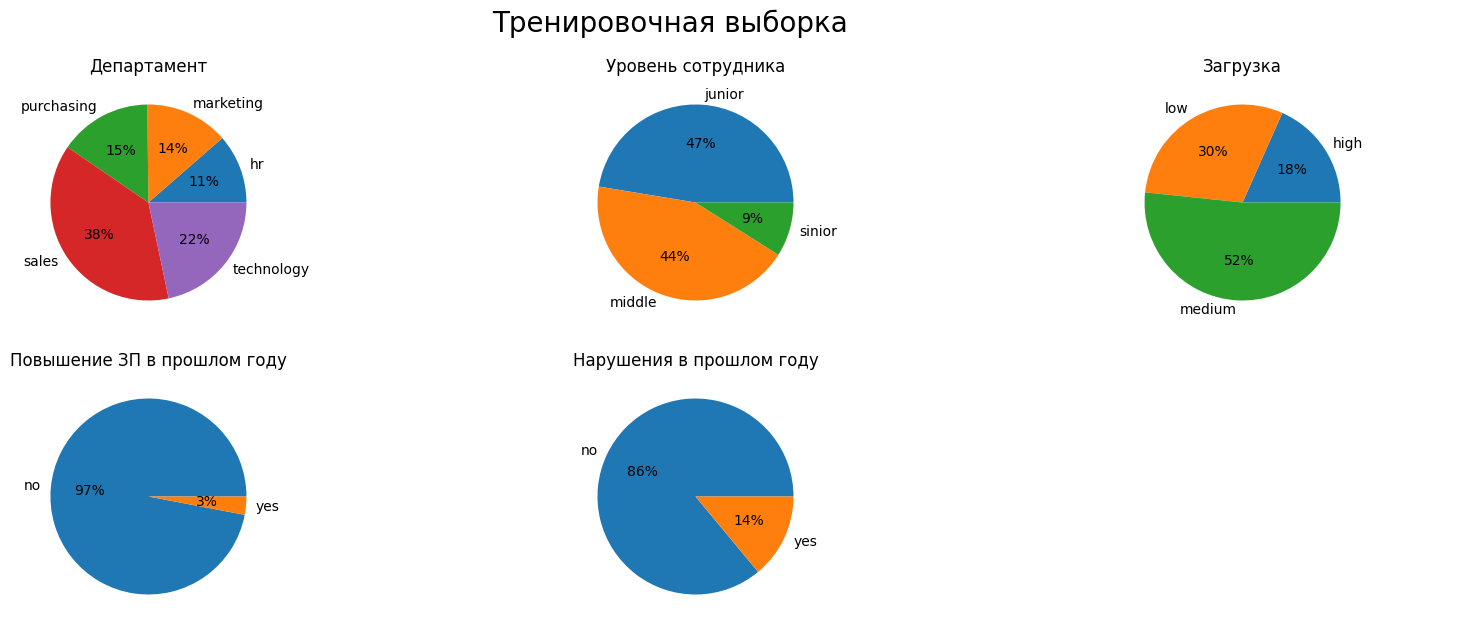

In [21]:
indexes = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]
titles = [
    'Департамент',
    'Уровень сотрудника',
    'Загрузка',
    'Повышение ЗП в прошлом году',
    'Нарушения в прошлом году'
]

categorical_property_visualization(
    data_= test_features_df,
    indexes_= indexes,
    titles_= titles,
    values_='id',
    aggfunc_='count',
    title_ = 'Тестовая выборка')


categorical_property_visualization(
    data_= train_job_satisfaction_rate_df,
    indexes_= indexes,
    titles_= titles,
    values_='id',
    title_ = 'Тренировочная выборка')

In [22]:
display(test_features_df.query('dept == " "'))
display(test_features_df.query('workload == " "'))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1609,822186,,middle,medium,3,no,no,4,38400,0.64


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1100,590867,marketing,junior,,4,no,no,4,28800,0.79


### `PipeLine` - замена пробелов и np.nan

In [23]:
ohe_columns_replace = [
    'dept',
    'workload'
]

ohe_replace_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'simpleImputer_ohe_space', 
            SimpleImputer(missing_values=' ', strategy='most_frequent')
        )
    ]
)

data_replace_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_replace_pipe, ohe_columns_replace),
    ]#, 
    #remainder='passthrough'
) 

In [24]:
test_features_df[ohe_columns_replace] = data_replace_preprocessor.fit_transform(test_features_df)

### Корреляционный анализ

In [25]:
train_job_satisfaction_rate_df = train_job_satisfaction_rate_df.sort_values(by=['id']).set_index('id')
test_features_df = test_features_df.sort_values(by=['id']).set_index('id')

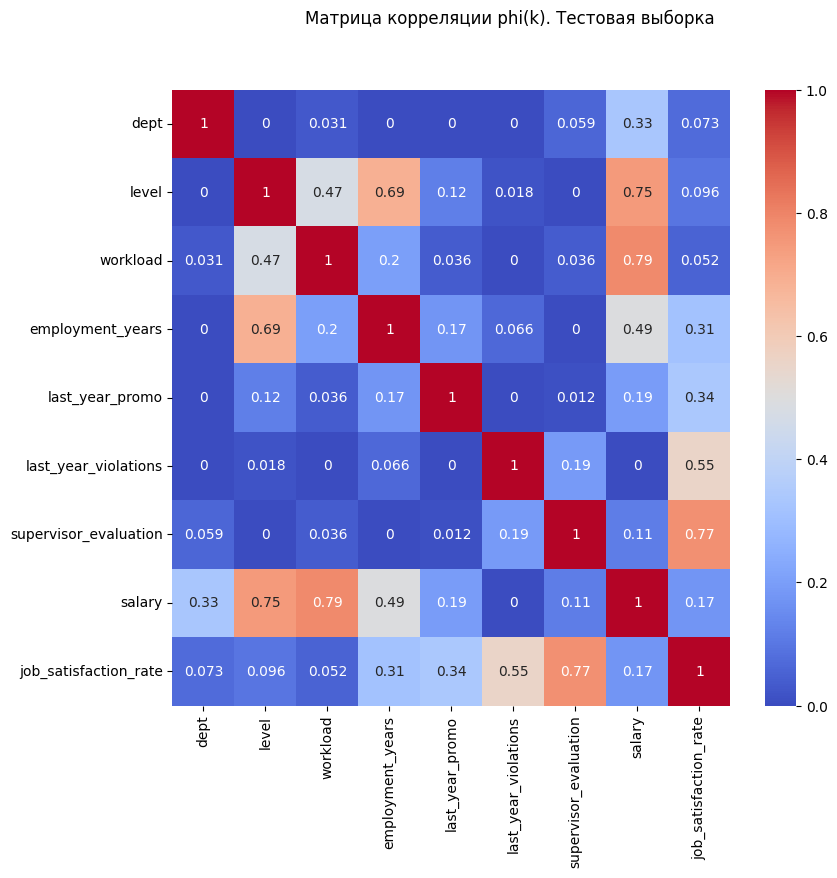

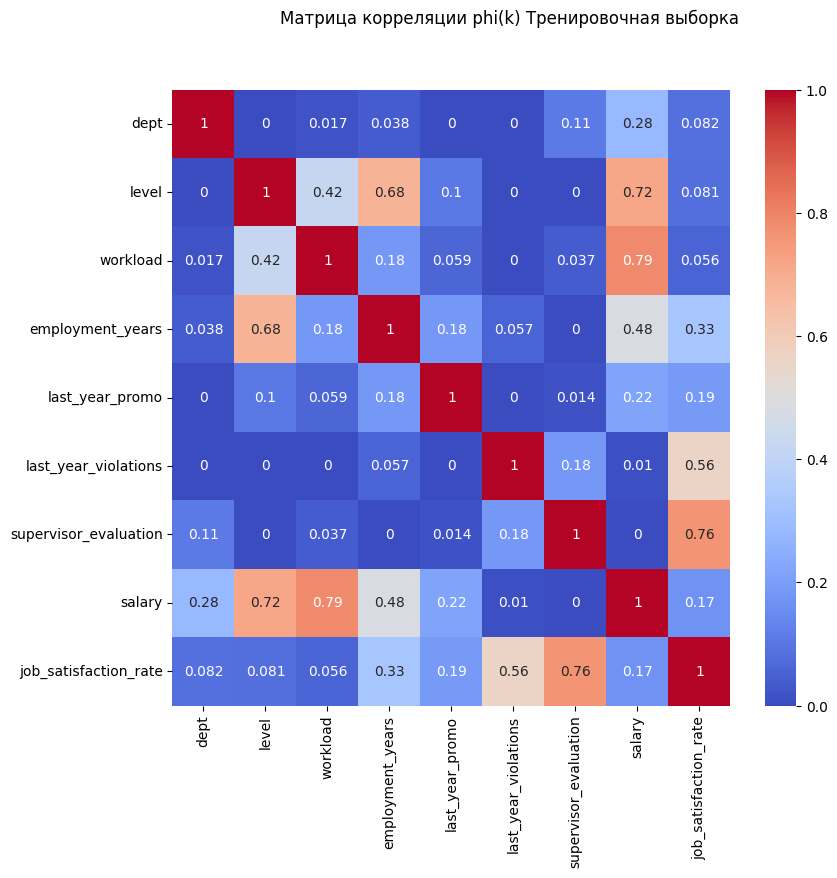

In [26]:
interval_cols = [
    'job_satisfaction_rate',
    'salary']

#display(train_job_satisfaction_rate_df[numeric_column].corr(method='spearman'))

plt.figure(figsize = (9, 8))
plt.suptitle('Матрица корреляции phi(k). Тестовая выборка')
sns.heatmap(test_features_df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

fig, ax = plt.subplots(figsize=(9, 8))
plt.suptitle('Матрица корреляции phi(k) Тренировочная выборка')
sns.heatmap(train_job_satisfaction_rate_df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

### Выводы (итоги)

* `dept`  - Отдел. Распределение сотрудников по отделам в обучающей и тестовой выборке почти одинаковое.
* `level` - Уровень занимаемой должности. Распределение сотрудников по этому признаку в обучающей и тестовой выборке почти одинаковое.
* `workload` - Уровень загруженности работников. в выборках. Распределение сотрудников по этому признаку в обучающей и тестовой выборке не отличаются.
* `employment_years` - Длительность работы в компании (в годах). Прослеживается зависимость количества сотрудников и длительности работы в компании.
* `last_year_promo` - Повышение за последний год. Распределение сотрудников по этому признаку в обучающей и тестовой выборке почти одинаковое.
* `last_year_violations` - Нарушения трудового договора. Распределение сотрудников по этому признаку в обучающей и тестовой выборке почти одинаковое.
* `supervisor_evaluation` - Оценка качества работы сотрудника. Распределение сотрудников по этому признаку в обучающей и тестовой выборке почти одинаковое. Максимальное количество сотрудников имеют оценки 3 и 4.
* `salary` - Ежемесячная зарплата сотрудника - распределение данных по этому признаку нормальное, есть выбросы. Распределение сотрудников по этому признаку в обучающей и тестовой выборке почти одинаковое.
* `job_satisfaction_rate` - Уровень удовлетворённости сотрудника работой в компании - имеет норммальное распределение, значения в обучающей и тестовой выборке примерно соответствуют друг другу.
* В колонках `dept`и `level`, значение полей = `' '` заменены на `np.nan`, пропуски будут обрабатываться на этапе разработки пайплайнов.
* Поле `id`, транформировано в индекс.
* В данных обнаружены выбросы.
* Между входными параметрами отсутствует связь выше 0,9 т.е. учитывать мультиколлинеарность нет необходимости. 
* На тренировочной и тестовой выборках, значения корреляции отличаются не значительно.

## Подготовка данных для моделирования

### Удаление дубликатов после формирование id - индекса

In [27]:
print(bold_start, 'Количество записей до удаления дублей   :', bold_end, len(train_job_satisfaction_rate_df))
train_job_satisfaction_rate_df = train_job_satisfaction_rate_df.drop_duplicates()
print(bold_start, 'Количество записей после удаления дублей:', bold_end, len(train_job_satisfaction_rate_df))

 Количество записей до удаления дублей   :  4000
 Количество записей после удаления дублей:  3755


### Определение целевого признака

In [28]:
RANDOM_STATE = 45

X_train = train_job_satisfaction_rate_df.drop('job_satisfaction_rate', axis=1)
y_train = train_job_satisfaction_rate_df['job_satisfaction_rate']

X_test = test_features_df.drop('job_satisfaction_rate', axis=1)
y_test = test_features_df['job_satisfaction_rate']

### Списки признаков по категориям

In [29]:
# Числовые признаки
num_columns = [
    'employment_years',
    'supervisor_evaluation',
    'salary']

# Категориальные признаки
ohe_columns = ['dept',
               'last_year_promo',
               'last_year_violations']
# Порядковые признаки
ord_columns = [
    'level',
    'workload']

### Создание пайплайнов

In [31]:
# Пайплайн подготовки признаков ohe_columns: заполнение пропусков и кодирование
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
        ('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)) #'error'
    ])

#  Пайплайн подготовки признаков ord_columns: заполнение пропусков и кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], # Категории поля level
                    ['low', 'medium', 'high']       # Категории поля workload
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# Общий пайплайн подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

### Выводы (итоги)

* Удалены дубликаты в тренировочной выборке 245 записей (после формирования индекса по полю - `id`). Удаление дублей улучшит значение SMAPE примерно на 0.3
* Заполнены пропуски.
* Входные параметры закодированны по типам (`ohe - OneHotEncoder`, `ord - OrdinalEncoder`).
* Реализовано масштабирование данных.

## Разработка и обучение моделей

### LinearRegression()

In [32]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None, 2, 3, 4, 5, 6],
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

calk_smape_scorer = make_scorer(score_func = calc_smape, greater_is_better = False)

lr_model = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring = calk_smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [DecisionTreeRegressor(random_state=45)],
                                         'models__max_depth': [None, 2, 3, 4, 5,
                                                               6],
                                         'models__max_features': range(2, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=45,
                   scoring=make_scorer(calc_smape, greater_is_better=False, response_method='predict'))

In [33]:
print(bold_start, 'Лучшая модель:\n', bold_end, lr_model.best_estimator_)
print('---------------------------------------------------------------------------------------------------------')
print (bold_start, 'best_score лучшей модели на кросс-валидации:', bold_end, lr_model.best_score_*(-1))

 Лучшая модель:
  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                          

In [34]:
pd.DataFrame(lr_model.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.043043,0.004553,0.010436,0.001461,MinMaxScaler(),9,None,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(random_state=45)}",-15.925132,-15.328042,-16.567908,-17.760674,-16.542751,-16.424901,0.808888,1
6,0.042103,0.003042,0.014362,0.000798,MinMaxScaler(),13,6,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 13, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=45)}",-18.022897,-19.436930,-19.040254,-20.433075,-19.588612,-19.304354,0.785401,2
5,0.038318,0.002047,0.014765,0.004056,passthrough,11,6,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': 'passthrough', 'models__max_features': 11, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=45)}",-18.022897,-19.463955,-19.056012,-20.433075,-19.588612,-19.312910,0.785331,3
1,0.057864,0.005603,0.015851,0.004207,StandardScaler(),9,6,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': StandardScaler(), 'models__max_features': 9, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=45)}",-18.800318,-19.507272,-19.336426,-20.542085,-19.903961,-19.618012,0.582384,4
8,0.037408,0.000940,0.011181,0.001288,passthrough,6,6,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': 'passthrough', 'models__max_features': 6, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=45)}",-19.523837,-19.997295,-22.068218,-23.981735,-26.424267,-22.399070,2.563279,5
3,0.038069,0.002410,0.017751,0.005692,passthrough,5,5,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': 'passthrough', 'models__max_features': 5, 'models__max_depth': 5, 'models': DecisionTreeRegressor(random_state=45)}",-26.405463,-21.652991,-21.255650,-23.100918,-22.041343,-22.891273,1.861423,6
2,0.043272,0.008862,0.013847,0.001427,StandardScaler(),4,5,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 5, 'models': DecisionTreeRegressor(random_state=45)}",-21.609432,-21.090620,-21.960591,-23.262152,-26.588764,-22.902312,1.977879,7
0,0.047881,0.002737,0.016365,0.003917,passthrough,6,4,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': 'passthrough', 'models__max_features': 6, 'models__max_depth': 4, 'models': DecisionTreeRegressor(random_state=45)}",-31.313289,-30.029767,-25.421240,-28.164405,-27.911811,-28.568103,2.008430,8
7,0.040492,0.001493,0.013763,0.001163,StandardScaler(),6,4,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': StandardScaler(), 'models__max_features': 6, 'models__max_depth': 4, 'models': DecisionTreeRegressor(random_state=45)}",-31.313289,-30.029767,-25.421240,-28.164405,-27.911811,-28.568103,2.008430,8
4,0.038700,0.002783,0.010974,0.001895,passthrough,3,2,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': 'passthrough', 'models__max_features': 3, 'models__max_depth': 2, 'models': DecisionTreeRegressor(random_state=45)}",-27.282976,-26.721067,-28.100402,-29.764671,-33.710328,-29.115889,2.516177,10


In [35]:
pred = lr_model.predict(X_test)

In [36]:
print(bold_start, 'SMAPE лучшей модели на тестовой выборке:', bold_end, round(calc_smape(y_test, pred),4))

 SMAPE лучшей модели на тестовой выборке:  14.379


### Выводы

* Лучшая модель определена: `DecisionTreeRegressor(max_features = 9, random_state = 45)`
* Параметры лучшей модели: `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=45)}`
* Модель удовлетворяет условию задания `SMAPE ≤ 15`. На тестовой выборке `SMAPE = 14.379`

# Задача 2: Предсказание увольнения сотрудника из компании

## Загрузка данных

In [38]:
train_quit_df = pd.read_csv('train_quit.csv')
train_quit_df.name = 'train_quit_df'

test_features_quit_df = pd.read_csv('test_features.csv')
test_features_quit_df.name = 'test_features_df'

test_target_quit_df = pd.read_csv('test_target_quit.csv')
test_target_quit_df.name = 'test_target_quit_df'

test_target_job_satisfaction_rate_df = pd.read_csv('test_target_job_satisfaction_rate.csv')
test_target_job_satisfaction_rate_df.name = 'test_target_job_satisfaction_rate_df'


display(train_quit_df.head(4))
display(test_features_quit_df.head(4))
display(test_target_quit_df.head(4))
display(test_target_job_satisfaction_rate_df.head(4))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72


### Выводы

Данные загружены без ошибок.

## Предобработка данных

### train_quit_df

In [ ]:
duplicates = df_inf(train_quit_df, head_row=5, drop_duplicates_flag=False)

### test_features_quit_df

In [ ]:
duplicates = df_inf(test_features_quit_df, head_row=5, drop_duplicates_flag=False)

### test_target_quit_df

In [ ]:
duplicates = df_inf(test_target_quit_df, head_row=5, drop_duplicates_flag=False)

### Выводы

* Данные соответствуют описанию.
* Дубликаты не обнаружены.
* Пропуски будут обработаны на этапе подготовки данных при разработке моделей.

## Исследование данных

 Поле : employment_years - employment_years 

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


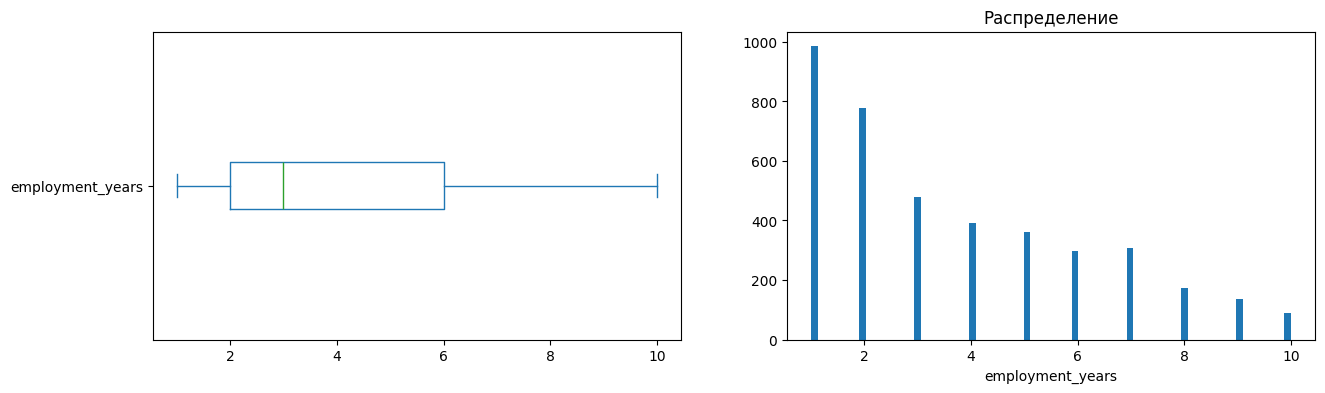

 Поле : salary - salary 

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


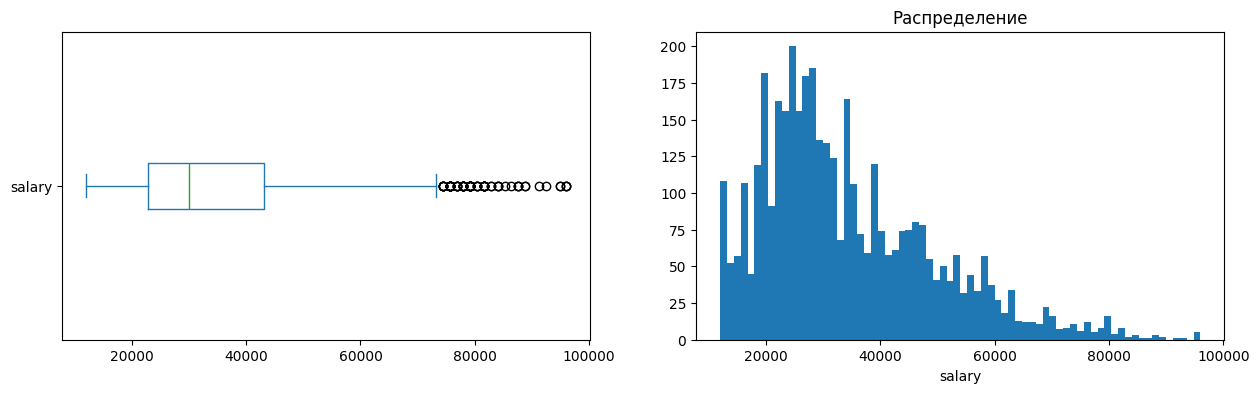

 Поле : supervisor_evaluation - supervisor_evaluation 

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


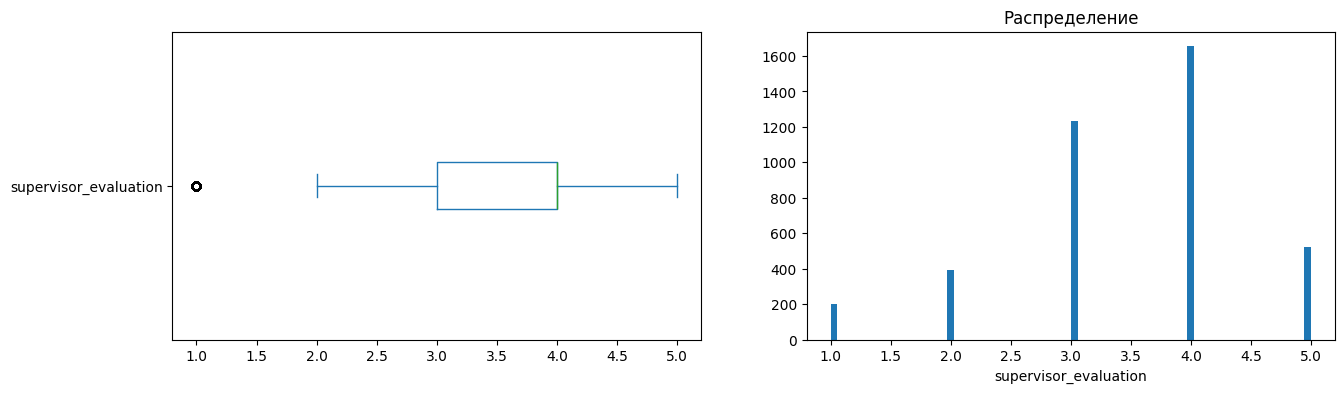

In [39]:
column_lst = [
    'employment_years',
    'salary',
    'supervisor_evaluation'
]

for column in column_lst:
    column_analiser(
        train_quit_df,
        column,
        x_label = column,
        y_label = '',
        print_unique = False
               )


In [40]:
test_features_quit_df[ohe_columns_replace] = data_replace_preprocessor.fit_transform(test_features_quit_df)

### Объединение тестовых наборов данных futures + target

In [41]:
test_features_quit_df.info()

salary_check = test_features_quit_df['salary'].sum()
test_features_quit_df = pd.merge(test_features_quit_df, test_target_quit_df, on='id', sort=True)
test_features_quit_df = pd.merge(test_features_quit_df, test_target_job_satisfaction_rate_df, on='id', sort=True).sort_values(by='id')
print('---------------------------------------------------------------------------------------------------------')
print(bold_start, 'salary_check = ', bold_end, salary_check)
print(bold_start, 'salary       = ', bold_end, test_features_quit_df['salary'].sum())
print('---------------------------------------------------------------------------------------------------------')

test_features_quit_df['job_satisfaction_rate_int'] = (round(test_features_quit_df['job_satisfaction_rate'], 1) * 10).astype(int)

test_features_quit_df.info()
test_features_quit_df.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
---------------------------------------------------------------------------------------------------------
 salary_check =   68133600
 salary       =   68133600
---------------------------------------------------------------------------------------------------------
<class 'pandas.

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate,job_satisfaction_rate_int
0,100298,hr,junior,low,2,no,no,4,19200,no,0.80,8
1,100480,marketing,junior,low,4,no,no,4,16800,no,0.84,8
2,100503,purchasing,middle,high,5,no,no,4,55200,no,0.79,8


 Поле : job_satisfaction_rate - Удовлетворенность работой 
 (работающие сотрудники)) 

count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


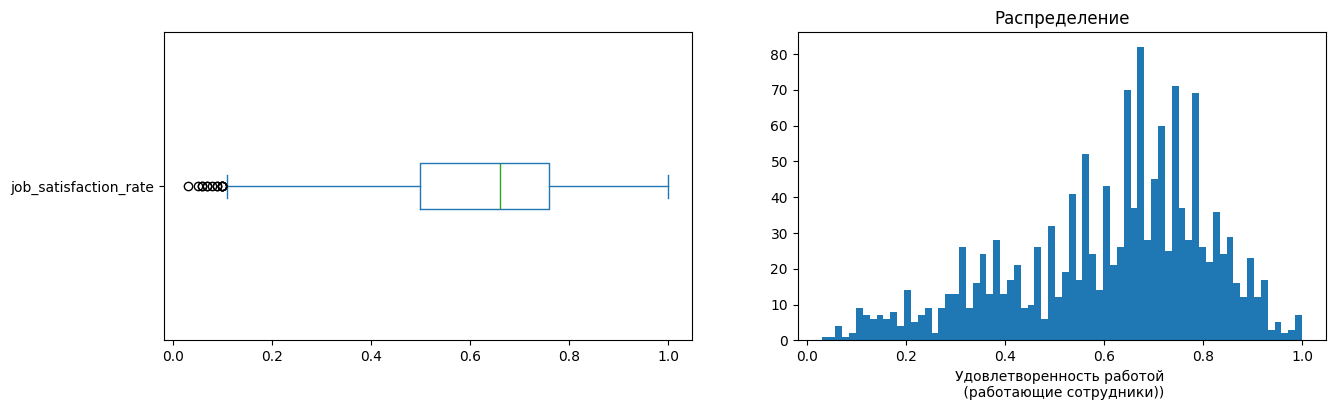

 Поле : job_satisfaction_rate - Удовлетворенность работой 
 (уволившиеся сотрудники)) 

count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64


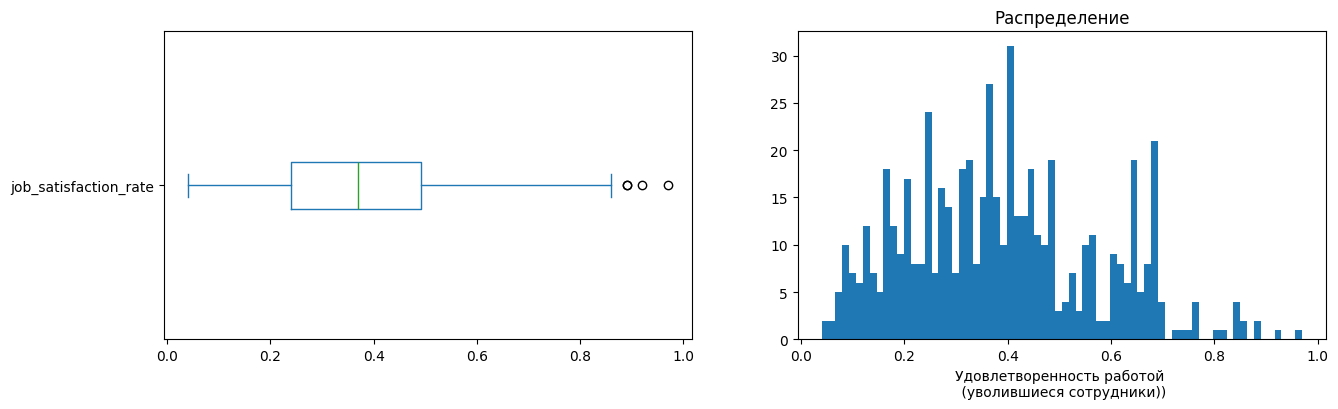

In [42]:
# Анализ удовлетворенности работающих сотрудников
column_analiser(
    test_features_quit_df.query('quit == "no"'),
    'job_satisfaction_rate',
    x_label = 'Удовлетворенность работой \n (работающие сотрудники))',
    y_label = '',
    print_unique = False
               )

# Анализ удовлетворенности уволившихся сотрудников
column_analiser(
    test_features_quit_df.query('quit == "yes"'),
    'job_satisfaction_rate',
    x_label = 'Удовлетворенность работой \n (уволившиеся сотрудники))',
    y_label = '',
    print_unique = False
               )

### Выводы

* Удовлетворенность работой у работающих сотрудников выше чем у уволившихся.

## Портрет «уволившегося сотрудника»

### Распределение сотрудников по парамметрам

 Распределение уволившихся и работающих сотрудников по значениям парамметров. 


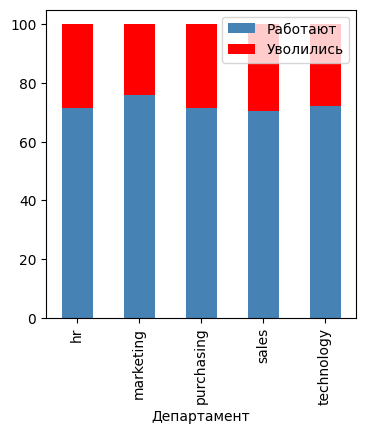

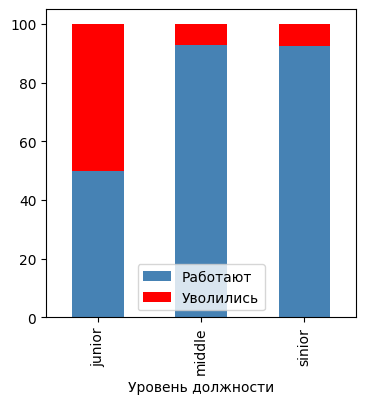

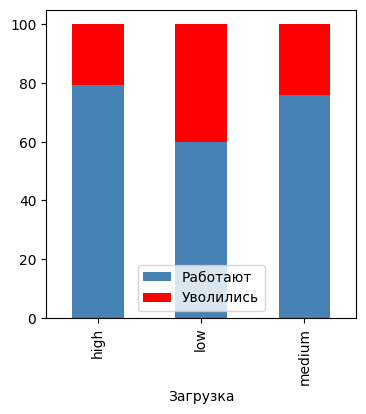

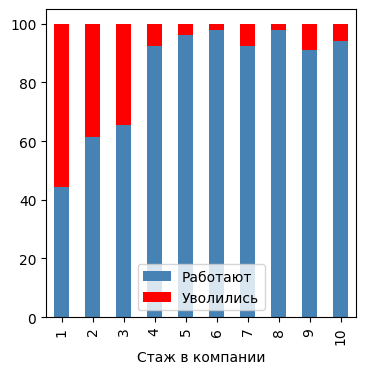

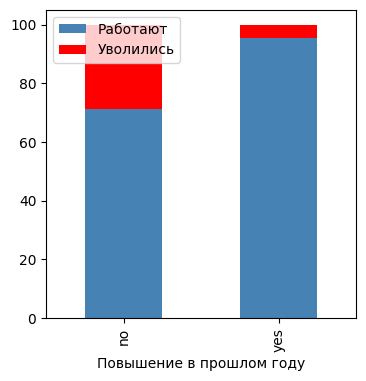

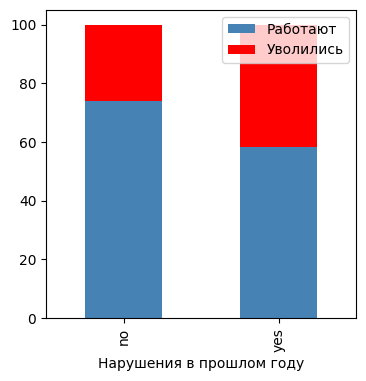

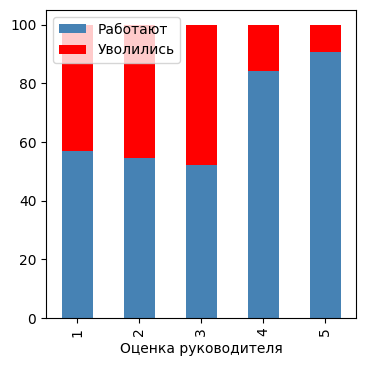

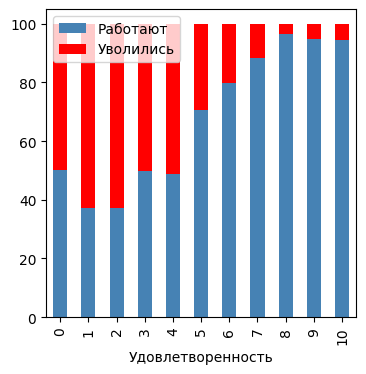

In [43]:
print(bold_start, 'Распределение уволившихся и работающих сотрудников по значениям парамметров.',bold_end)
attrition_visualization('dept', 'Департамент', test_features_quit_df)
attrition_visualization('level', 'Уровень должности', test_features_quit_df)
attrition_visualization('workload', 'Загрузка', test_features_quit_df)
attrition_visualization('employment_years', 'Стаж в компании', test_features_quit_df)
attrition_visualization('last_year_promo', 'Повышение в прошлом году', test_features_quit_df)
attrition_visualization('last_year_violations', 'Нарушения в прошлом году', test_features_quit_df)
attrition_visualization('supervisor_evaluation', 'Оценка руководителя', test_features_quit_df)
attrition_visualization('job_satisfaction_rate_int', 'Удовлетворенность', test_features_quit_df)

### Степень удовлетворенности сотрудника

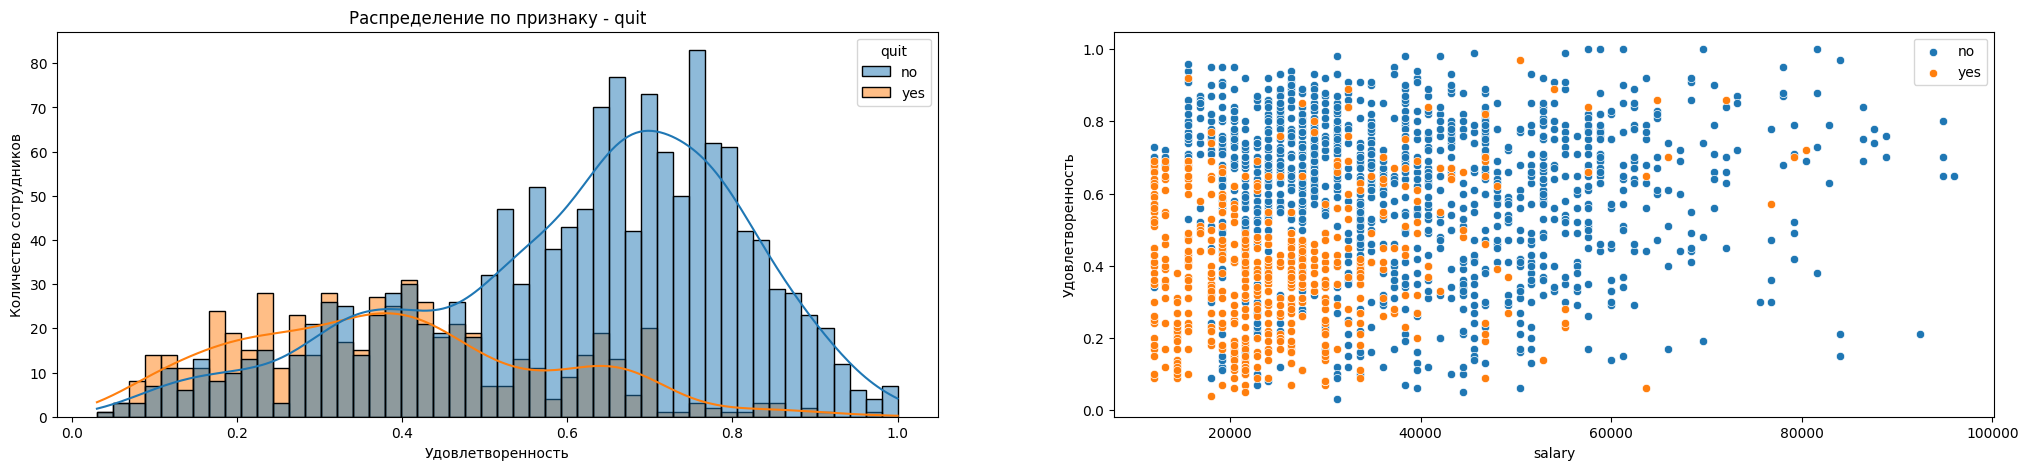

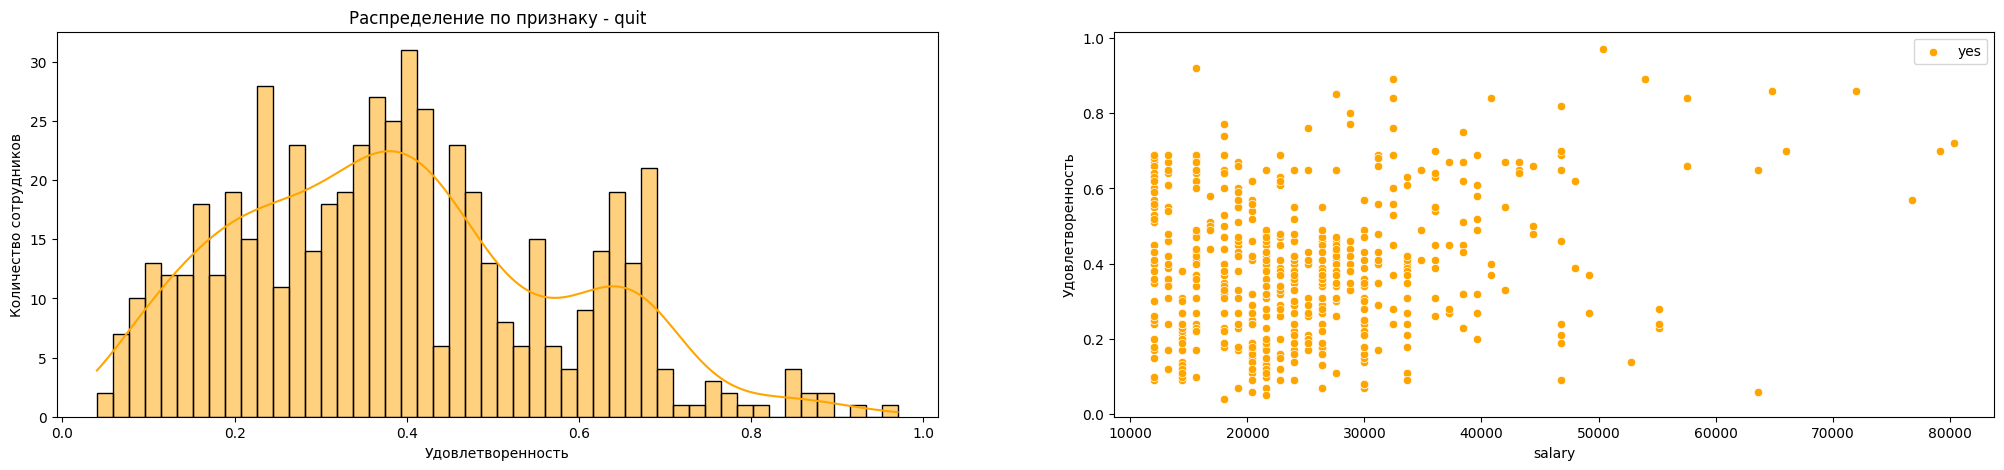

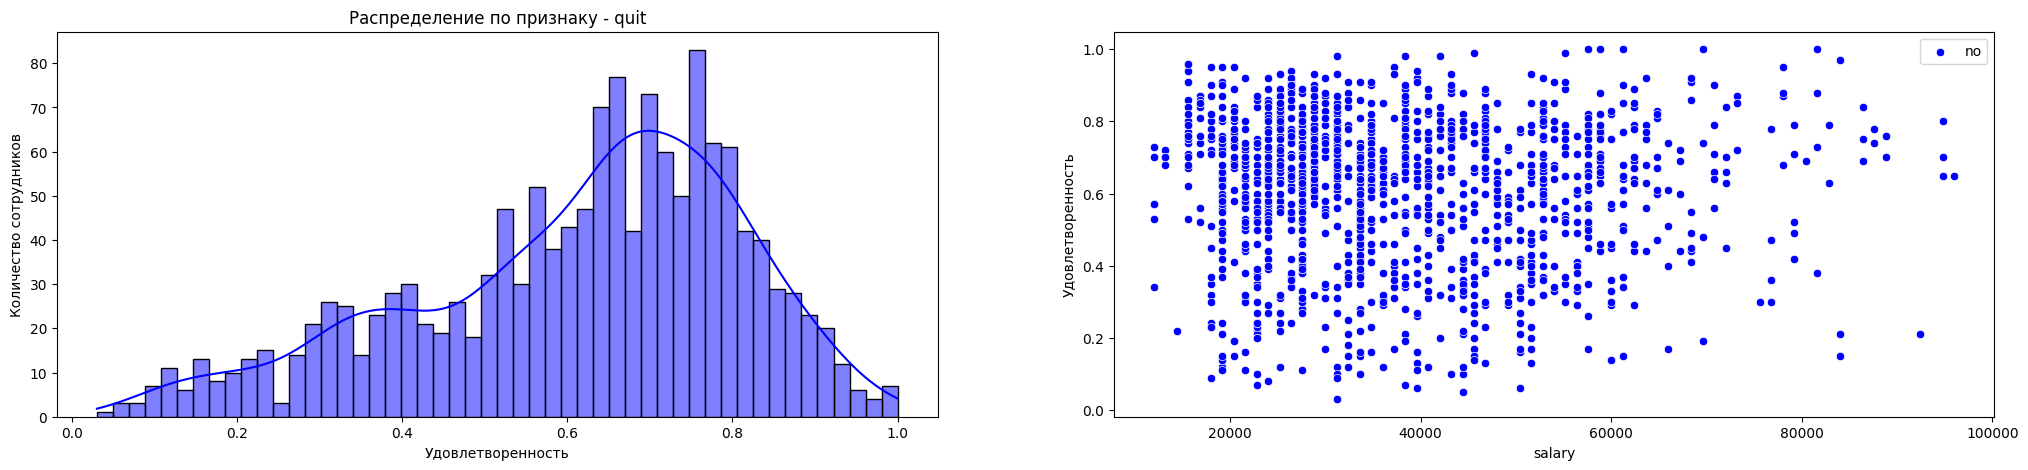

In [44]:
research_field = 'job_satisfaction_rate'
research_field_histplot_title_y = 'Количество сотрудников'
research_field_title = 'Удовлетворенность'

property_fields = [
    'salary'
#    'employment_years',
#    'supervisor_evaluation'
]


property_labels = property_fields

data_fields = [
               'quit'
#               'dept',
#               'last_year_promo',
#               'last_year_violations',
]


labels = data_fields

distribution_visualization(
    data_ = test_features_quit_df,
    research_field_ = research_field,
    research_field_title_x_ = research_field_title,
    research_field_title_y_ = research_field_title,
    property_fields_ = property_fields,
    property_labels_ = property_labels,
    data_fields_ = data_fields,
    labels_ = labels,
    research_field_histplot_title_y_ = research_field_histplot_title_y,
    fig_size_ = [25, 5])

distribution_visualization(
    data_ = test_features_quit_df.query('quit == "yes"'),
    research_field_ = research_field,
    research_field_title_x_ = research_field_title,
    research_field_title_y_ = research_field_title,
    property_fields_ = property_fields,
    property_labels_ = property_labels,
    data_fields_ = data_fields,
    labels_ = labels,
    uni_color_ = 'orange',
    research_field_histplot_title_y_ = research_field_histplot_title_y,
    fig_size_ = [25, 5])

distribution_visualization(
    data_ = test_features_quit_df.query('quit == "no"'),
    research_field_ = research_field,
    research_field_title_x_ = research_field_title,
    research_field_title_y_ = research_field_title,
    property_fields_ = property_fields,
    property_labels_ = property_labels,
    data_fields_ = data_fields,
    labels_ = labels,
    uni_color_ = 'blue',
    research_field_histplot_title_y_ = research_field_histplot_title_y,
    fig_size_ = [25, 5])

### T-test по удовлетворенности сотрудников

In [45]:
quit_yes = test_features_quit_df[test_features_quit_df['quit'] == 'yes']
quit_no  = test_features_quit_df[test_features_quit_df['quit'] == 'no']

## равные дисперсии генеральной совокупности
print(ttest_ind(quit_yes['job_satisfaction_rate'], quit_no['job_satisfaction_rate']))
## дисперсии генеральной совокупности не равны
print(ttest_ind(quit_yes['job_satisfaction_rate'], quit_no['job_satisfaction_rate'], equal_var= False ))
print('---------------------------------------------------------------------------------------------------------')
print(bold_start, 'Медиана ЗП (работающие сотрудники) =', bold_end, test_features_quit_df.query('quit == "no"')['salary'].median())
print(bold_start, 'Медиана ЗП (уволившиеся сотрудники) =', bold_end, test_features_quit_df.query('quit == "yes"')['salary'].median())

TtestResult(statistic=-23.074784903634534, pvalue=1.231122066517193e-104, df=1998.0)
TtestResult(statistic=-23.795097591114747, pvalue=2.7708628031539788e-101, df=1099.2247109659888)
---------------------------------------------------------------------------------------------------------
 Медиана ЗП (работающие сотрудники) =  33600.0
 Медиана ЗП (уволившиеся сотрудники) =  22800.0


### Выводы

* **Стаж:**
    * Максимальное количество уволившихся составляют сотрудники, стаж работы в компании которых, не превышает 3 года:
        * 1 год - 52%
        * 2 года - 26%
        * 3 года - 14%
    * **С ростом стажа снижается процент увольнений**
* **Уровень сотрудника:**
    * Максимальную долю уволившихся составляют **junior** - сотрудники **87%**
    * Доля уволившихся Сотрудники уровня **middle** составляет **11%**
    * Доля уволившихся Сотрудники уровня **sinior** составляет **2%**
    * **Чем выше уровень сотрудника, тем меньше процент уволившихся сотрудников**
* 99% уволившихся сотрудников не получали повышения в прошлом году (**можно предположить, что это сотрудники со стажем не более 1 года**)
* Максимальные доли сотрудников уволились из **sales (40%)** и **tecnology (23%)** департаментов
* **81%** уволившихся сотрудников не нарушали трудовой договор
* Максимальные доли уволилившихся сотрудников получили оценки руководителей:
    * 2 - 16%
    * 3 - 49%
    * 4 - 24%
* Для анализа долей уволившихся сотрудников был сформирован показатель удовлетворенности `job_satisfaction_rate_int` = показателю удовлетворенности `job_satisfaction_rate`, округленному до целого.
    * Максимальные доли (> 10%) уволившихся составляли сотрудники с показателем `job_satisfaction_rate_int` в диапазоне от 2х до 6ти. 
    * Уволившиеся сотрудники с `job_satisfaction_rate_int` = 1 составили 9%.
* Значение медианы зарплаты уволившихся сотрудников составляет 22800.0, работающих сотрудников - 33600.0. Эти показатели могут подтверждать, что в основном увольняются **junior** - сотрудники.
* t-test показателя `job_satisfaction_rate` по уволившимся и работающим сотрудникам подтвердил гипотезу о том, что есть зависимость между удовлетворенностью и увольнениями.
    * **H0**: Средние значения совокупной выборки равны, т.е. зависимости между увольнением и удовлетворенностью работой нет.
    * **H1**: Средние значения совокупной выборки не равны, т.е. есть зависимость между увольнением и удовлетворенностью работой.
    * pvalue < 0.05 - **H0** отвергается.

## Подготовка данных и формирование моделей

### Формирование признака `job_satisfaction_rate` по результатам первой задачию для тренировочной и тестовой выборок.

In [46]:
train_quit_df['job_satisfaction_rate'] = lr_model.predict(train_quit_df)
test_features_quit_df['job_satisfaction'] = lr_model.predict(test_features_quit_df)

train_quit_df.info()
print('---------------------------------------------------------------------------------------------------------')
test_features_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   quit                   4000 non-null   object 
 10  job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 343.9+ KB
---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeInde

### Перевод id в индекс. Удаление дубликатов.

In [47]:
train_quit_df = train_quit_df.sort_values(by=['id']).set_index('id')
test_features_quit_df = test_features_quit_df.sort_values(by=['id']).set_index('id')

In [48]:
train_quit_df.info()
print('---------------------------------------------------------------------------------------------------------')
train_quit_df = train_quit_df.drop_duplicates()
train_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 100222 to 999915
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   quit                   4000 non-null   object 
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 343.8+ KB
---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 2587 entries, 100222 to 999915
Data columns (total 1

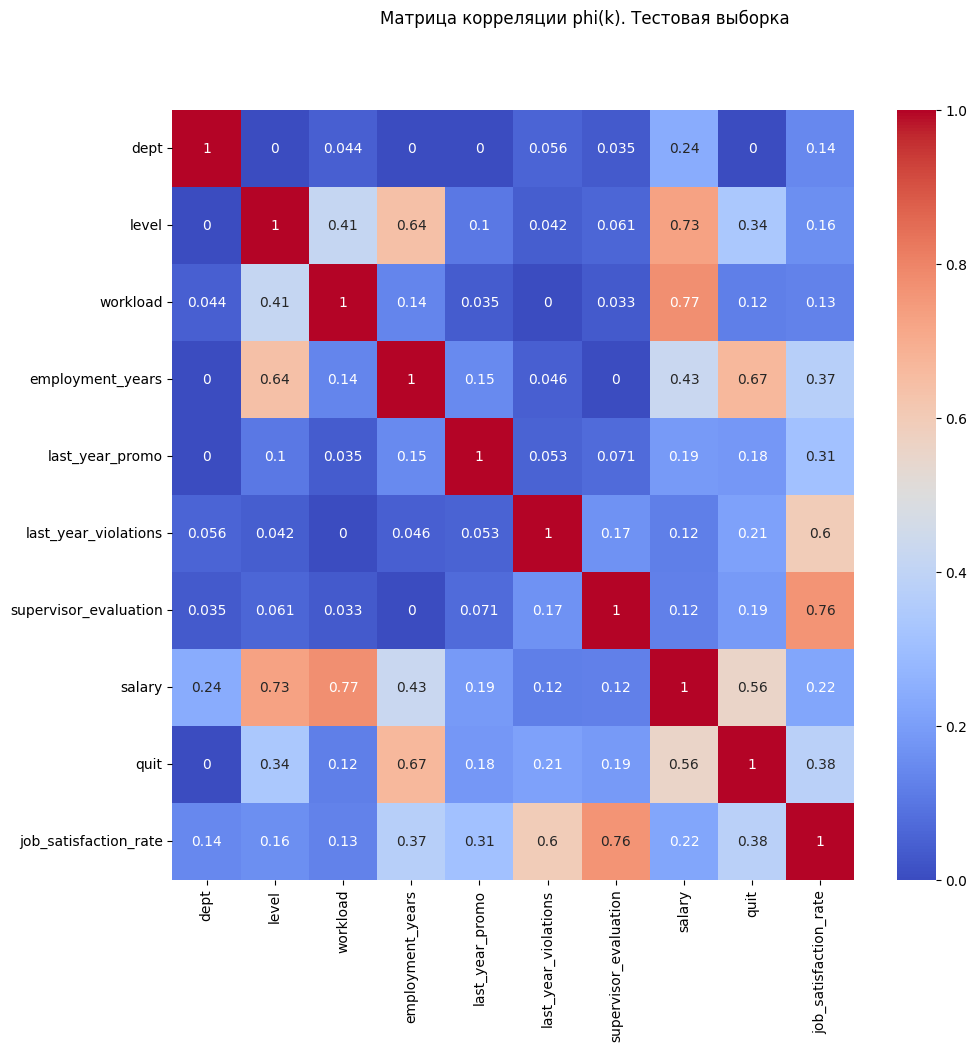

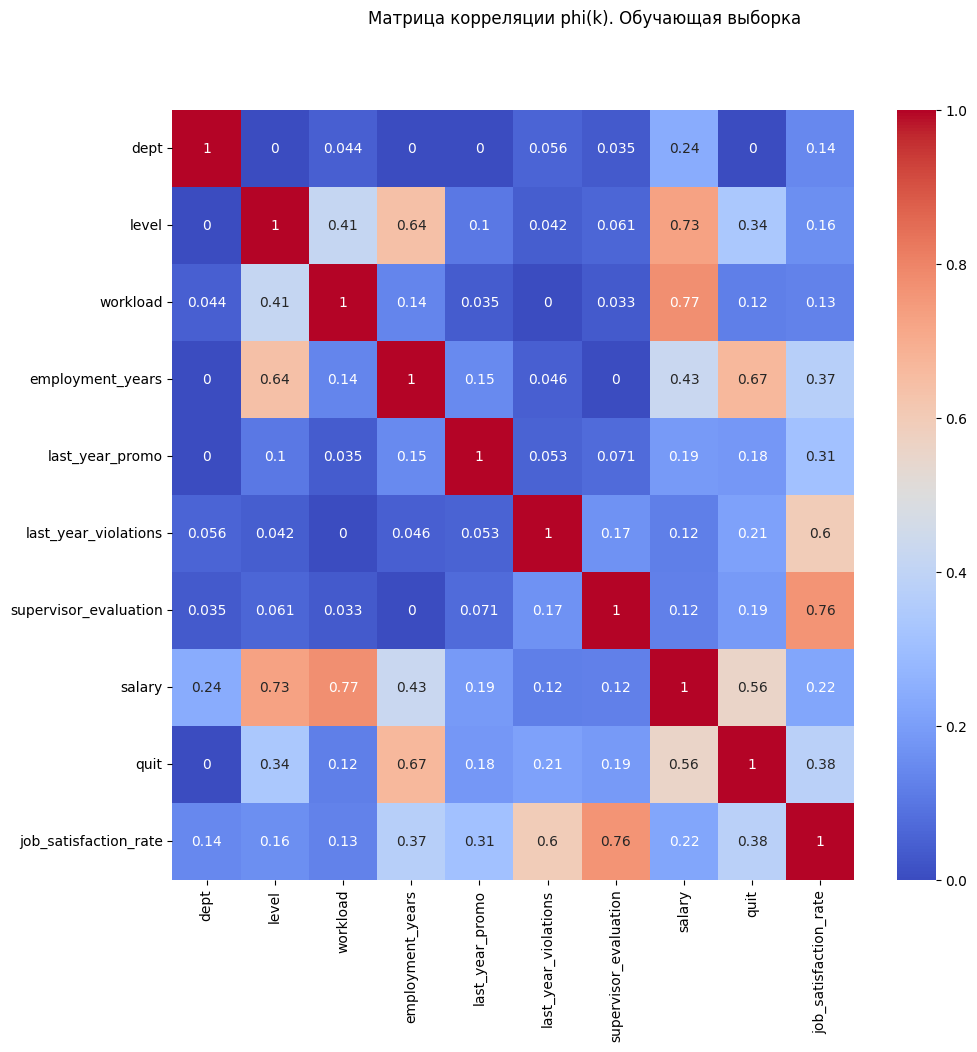

In [49]:
interval_cols = ['salary', 'job_satisfaction_rate']

fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k). Тестовая выборка')
sns.heatmap(train_quit_df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k). Обучающая выборка')
sns.heatmap(train_quit_df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

### Кодирование таргета обучающей и тестовой выборок

In [50]:
label_encoder = LabelEncoder()
label_encoder.fit_transform(train_quit_df['quit'].unique())

train_quit_df['quit'] = label_encoder.transform(train_quit_df['quit'])

test_features_quit_df['quit'] = label_encoder.transform(test_features_quit_df['quit'])

print('Поле quit содержало значения - ', label_encoder.classes_)
print('Значения после кодирования - ', label_encoder.transform(label_encoder.classes_))

Поле quit содержало значения -  ['no' 'yes']
Значения после кодирования -  [0 1]


### Определение целевого признака

In [51]:
#X_train_quit = train_quit_df.drop(['quit', 'salary'], axis=1)
X_train_quit = train_quit_df.drop(['quit'], axis=1)
y_train_quit = train_quit_df['quit']

#X_test_quit = test_features_quit_df.drop(['quit', 'salary'], axis=1)
X_test_quit = test_features_quit_df.drop(['quit'], axis=1)
y_test_quit = test_features_quit_df['quit']

### Подготовка данных, разработка словарей

In [52]:
num_columns = [
    'employment_years',
    'supervisor_evaluation',
    'salary',
    'job_satisfaction_rate']

ohe_columns = [
        'dept',
        'last_year_promo',
        'last_year_violations']

ord_columns = ['level', 'workload']


# Формирование data_preprocessor

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
)

X_train_quit_transformed = \
    pd.DataFrame(data_preprocessor.fit_transform(X_train_quit), columns=data_preprocessor.get_feature_names_out())
X_test_quit_transformed = \
    pd.DataFrame(data_preprocessor.transform(X_test_quit), columns=data_preprocessor.get_feature_names_out())

#X_train_quit_transformed.info()
#print('---------------------------------------------------------------------------------------------------------')
#X_test_quit_transformed.info()

In [53]:
# Итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1'))
#    ('models', SVC(random_state=RANDOM_STATE, probability=True)),
#    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # Словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
#        'models__criterion': ['gini', 'entropy', 'log_loss'],
#        'models__splitter': ['best', 'random'],
        'models__max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'models__max_leaf_nodes': range(1, 270),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
                                   
    # Словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # Словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # Словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

quit_model = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

### Выводы (итоги)

* Сформирован входной признак `job_satisfaction_rate`. Использован прогноз по выбранной модели из Задачи 1.
* Сформирован индекс на основе поля `id`. Поле 'id' исключено из выборок, т.к. не является признаком для обучения и тестирования.
* Поле quit содержало значения -  `['no' 'yes']`. Соответствующие значения после кодирования -  `[0 1]`
* Признаки разделены по категориям:
    * num_columns - `employment_years`, `supervisor_evaluation`, `salary`, `job_satisfaction_rate`
    * ohe_columns - `dept`, `last_year_promo`, `last_year_violations`
    * ord_columns - `level`, `workload`


## Определение и анализ лучшей модели

### Обучение моделей, определение лучшей

In [54]:
quit_model.fit(X_train_quit, y_train_quit)

print(bold_start, 'Лучшая модель и её параметры:\n', bold_end, quit_model.best_estimator_)
print('---------------------------------------------------------------------------------------------------------')
print (bold_start, 'Метрика лучшей модели на на кросс-валидации:', bold_end, quit_model.best_score_)
print('---------------------------------------------------------------------------------------------------------')
roc_auc_quit_model = roc_auc_score(y_test_quit, quit_model.predict_proba(X_test_quit)[:, 1])
print(bold_start, 'roc_auc лучшей модели -', bold_end, round(roc_auc_quit_model, 3))
print('---------------------------------------------------------------------------------------------------------')
display(pd.DataFrame(lr_model.cv_results_).sort_values(by=['rank_test_score'])[
    ['rank_test_score',
     'mean_test_score',
     'param_models',
     'params']]) ## .head(1)

 Лучшая модель и её параметры:
  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                           

,rank_test_score,mean_test_score,param_models,params
9,1,-16.424901,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(random_state=45)}"
6,2,-19.304354,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 13, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=45)}"
5,3,-19.312910,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': 'passthrough', 'models__max_features': 11, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=45)}"
1,4,-19.618012,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': StandardScaler(), 'models__max_features': 9, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=45)}"
8,5,-22.399070,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': 'passthrough', 'models__max_features': 6, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=45)}"
3,6,-22.891273,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': 'passthrough', 'models__max_features': 5, 'models__max_depth': 5, 'models': DecisionTreeRegressor(random_state=45)}"
2,7,-22.902312,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 5, 'models': DecisionTreeRegressor(random_state=45)}"
0,8,-28.568103,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': 'passthrough', 'models__max_features': 6, 'models__max_depth': 4, 'models': DecisionTreeRegressor(random_state=45)}"
7,8,-28.568103,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': StandardScaler(), 'models__max_features': 6, 'models__max_depth': 4, 'models': DecisionTreeRegressor(random_state=45)}"
4,10,-29.115889,DecisionTreeRegressor(random_state=45),"{'preprocessor__num': 'passthrough', 'models__max_features': 3, 'models__max_depth': 2, 'models': DecisionTreeRegressor(random_state=45)}"


### Значимость признаков модели `DecisionTreeClassifier`.

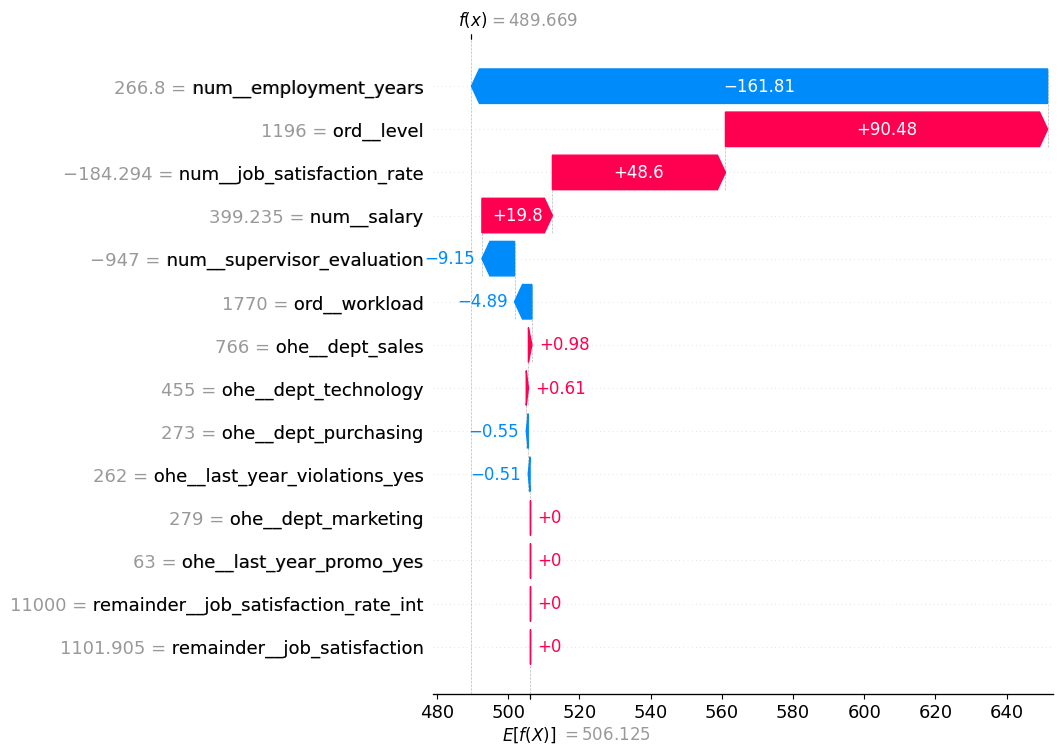

In [55]:
best_model = quit_model.best_estimator_

X_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_test_quit), columns=data_preprocessor.get_feature_names_out())
explainer = shap.TreeExplainer(best_model.named_steps['models'])
shap_values = explainer(X_transformed)

shap_values_sum = 0
for i in range(1, len(shap_values)):
    shap_values_sum += shap_values[i]

#shap.plots.waterfall((shap_values_sum.abs[:,1]), max_display=20)
shap.plots.waterfall((shap_values_sum[:,1]), max_display=20)

plt.show()

### Выводы

* Лучшая модель - `DecisionTreeRegressor`
* Параметры лучшей модели - `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=45)}`
* `ROC-AUC` лучшей модели - 0.925, что соответствует требованиям задачи.
* Значимые признаки лучшей модели:
    * `employment_years` - стаж в компании
    * `level` - уровень сотрудника
    * `job_satisfaction_rate` - удовлетворенность работой
    * `salary` - зарплата
    * `workload` - уровень загруженности сотрудника

# Общий вывод

* **В рамках проекта были определены две задачи:**
    * Задача 1: Разработка модели прогноза уровня удовлетворённости сотрудника
    * Задача 2: Предсказание увольнения сотрудника из компании

* **По обеим задачам были реализованы этапы Предобработки и Исследования данных. Проверялись: структура, типы и значения предоставленных данных.**
    * Представленные данные соответствуют описанию
    * Явных дубликатов обнаружено не было
    * Типы предоставленных данных соответствуют поставленным задачам
    * Обнаруженные значения `" "` поллей `dept` и `workload` заменены на пустые значения.
    * Пустые значения полей (пропуски) заменены на часто встречающиеся значения.

* **Задача 1**
    * **Разработана модель прогноза удовлетворенности:**
        * Лучшая модель: `DecisionTreeRegressor(max_features = 9, random_state = 45)`
        * Параметры лучшей модели: `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=45)}`
        * Модель удовлетворяет условию задания `SMAPE ≤ 15`. На тестовой выборке метрика лучшей модели `SMAPE = 14.379`

* **Задача 2**
    * **Составлен "Портрет уволившегося сотрудника":**
        * Максимальное количество уволившихся составляют сотрудники, стаж работы в компании которых, не превышает 3 года:
            * 1 год - 52%
            * 2 года - 26%
            * 3 года - 14%
        * Максимальную долю уволившихся составляют junior - сотрудники 87%
        * 99% уволившихся сотрудников не получали повышения в прошлом году
        * Максимальные доли уволилившихся сотрудников получили оценки руководителей: 2 - 16%, 3 - 49%, 4 - 24%
        * Максимальные доли (> 10%) уволившихся составляли сотрудники с показателем job_satisfaction_rate_int в диапазоне от 2х до 6ти.
        * Уволившиеся сотрудники с job_satisfaction_rate_int = 1 составили 9%.
        * Значение медианы зарплаты уволившихся сотрудников составляет 22800.0, работающих сотрудников - 33600.0. Эти показатели могут подтверждать, что в основном увольняются junior - сотрудники.
        * t-test показателя job_satisfaction_rate по уволившимся и работающим сотрудникам подтвердил гипотезу о том, что есть зависимость между удовлетворенностью и увольнениями.
    * **Разработана модель прогноза увольнений.**
        * Лучшая модель - `DecisionTreeRegressor`
        * Параметры лучшей модели - `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=45)}`
        * `ROC-AUC` лучшей модели - 0.925, что соответствует требованиям задачи.
    * **Определены Значимые признаки лучшей модели:**
        * `employment_years` - стаж в компании
        * `level` - уровень сотрудника
        * `job_satisfaction_rate` - удовлетворенность
        * `salary` - зарплата
<br>

**Предложения для бизнеса:**<br>
* По Портрету уволившегося сотрудника видно, что основная текучка наблюдается среди junior-сотрудников и сотрудников, стаж которых не превышает 3 года.
* Первые по значимости признаки модели прогнозирования увольнений те же признаки: стаж и уровень занимаемой должности.
* Для удержания "молодых" джунов может быть эффективен пересмотр системы KPI (оценка руководителем) и соответствующая бонусная система. Не надо забывать, что уровень ЗП - тоже значимый признак модели предсказания увольнений.
* Уровень занимаемой должности - второй по значимости признак сотрудника при построении прогноза увольнений. Для снижения текучки кадров может быть полено разработать корпоративную систему Управления карьерным ростом, которая позволит сотрудникам "увидеть" карьерные перспективы и реализовать в компании.